Import Libraries

In [1]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  # Import TensorFlow after Scipy or Scipy will break
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

This pre-trained network can be downloaded [here](http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat). I did not include it in the repository because it is 500 MB.

In [2]:
from vgg_config import load_vgg_model
vgg = load_vgg_model('imagenet-vgg-verydeep-19.mat')

Instructions for updating:
Colocations handled automatically by placer.


- Content (c)
- Style (s)
- Generated (g)


### Visualizing What a deep network is learning
[Zeiler and Fergus, 2013, Visualizing and Understanding Convolutional Networks]

Gist: Pick a unit in layer 1. Find the nine image patches that maximize that unit's activation.

### Cost Function
[Gatys et al., 2015. A neural algorithm of artistic style]
- Use Gradient descent to minimize J(G) = alpha * Jcontent(C, G) + beta* Jstyle(S, G)
- Steps:
    - 1: Initiate G randomly (G: [100 x 100 x 3] matrix)
    - 2: Use gradient descent to minimize J(G)
    - 3: Repeat
#### Content cost:
- Say you use hidden layer *l* to compute content cost
    - Use pre-trained ConvNet (e.g. VGG network)
    - Let a^[l](C) and a^[l](G) be the activation of layer l on the images
    - If a^[l](C) and a^[l](G) are similar, both images have similar content

#### Style cost:
- Take a layer of the network and visualize the different components as described in vid 2. Take correlations between each component (e.g. do vertical lines correspond with orange colors?)


# Current todo's
- Visualize hidden layers for content vs style
- Source / expand description for VGG19
- Compare eager execution vs. fast style transfer
- Texture transfer

# Load images

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [4]:
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [3]:
#tf.enable_eager_execution()

In [5]:
def load_img(path_to_img, max_dim = 512):
    """
    purpose: 
        Reshape an input image into dimensions compatible with VGG19 model
    
    details:
        1) Load image
        2) Resize to maximum dimension size
        3) Store image in numpy array
        4) Convert 3D image into 4D via np.expand()
        
    args:
        path_to_img (string)    file location of image
        max_dim     (integer)   maximum dimensions for rescaling large images
        
    rets:
        img         (np array)  rescaled 4D image array
    """
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long

    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    return img


def imshow(img, ax, title=None):
    """
    purpose:
        -Remove 4th dimension from image array, plot via
        matplotlib.pyplot.imshow()
        
    args:
        img    (np array)    4D representation of image
        ax     (plt Axes)    Location of plotted image
        title  (string)      Title for plotted image
    """
    out = np.squeeze(img, axis=0).astype('uint8')
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.imshow(out)
    if title:
        ax.set_title(title)    
        

In [6]:
def reshape_images(content_image, style_image):
    _, w, h, _ = content_image.shape
    style_image = style_image[:,:w,:h,:] #reshape style
    
    _, w, h, _ = style_image.shape
    content_image = content_image[:,:w,:h,:] #reshape content
    return content_image, style_image

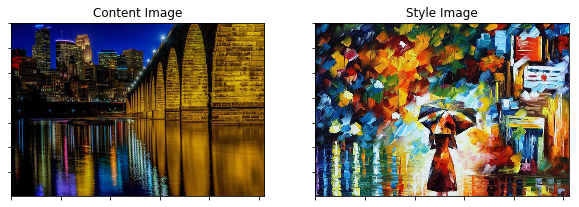

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

content_image = load_img('data/content/stonearch.jpg').astype('uint8')
style_image = load_img('data/style/rainPrincess.jpg').astype('uint8')

content_image, style_image = reshape_images(content_image, style_image)


imshow(content_image, ax[0], 'Content Image')
imshow(style_image, ax[1], 'Style Image')
plt.show()

# Preprocess Data

If you've used Photoshop or similar software, you are probably used to the RGB convention of images. The [VGG Networks](https://arxiv.org/pdf/1409.1556.pdf) works with BGR instead. It also preprocesses the images by normalizing BGR through subtracting [103.939, 116.779, 123.68]

In [8]:
def load_and_process_img(path_to_img):
    """
    purpose:
        apply vgg19 preprocessing to image
    args:
        path_to_img   (string)   file location of image
    rets:
        img           (np array) 4D representation of image
    """
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    """
    purpose:
        reverse vgg19 preprocessing
    details:
        -add [103.939, 116.779, 123.68] to respective BGR vectors
        -remove 4th dimension from image
    args:
        processed_img (4D np array)
    rets:
        img (3D np array)
    """
    img = processed_img.copy()
    if len(img.shape) == 4:
        img = np.squeeze(img, 0)
    else:
        raise ValueError("Invalid input to deprocessing image")

    img[:, :, 0] += 103.939 # Blue
    img[:, :, 1] += 116.779 # Green
    img[:, :, 2] += 123.68  # Red
    img = img[:, :, ::-1]   # 4D to 3D

    img = np.clip(img, 0, 255).astype('uint8')
    return img

# Build Model

todos - change maxpool layers to average pool

Following the original [NST paper](https://arxiv.org/pdf/1508.06576.pdf), we will use the [VGG-19 Network](https://arxiv.org/pdf/1409.1556.pdf)

In [11]:
#vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
#vgg.trainable = False

![VGG19 - Clifford K. Yang](img/vgg19.jpg)

The *Visual Geometry Group* (VGG) has published this pre-trained model, which gets its name from the 16 convolutional layers + 3 fully-connected layers. Its original purpose was image classification - it can detect 1,000 different objects in an image.

We are not interested in image classification, however, because this model was trained on over 1-million images from the [ImageNet](http://www.image-net.org/) database, it can effectively separate low-level features (at the earlier layers) from the high level features (at the deeper layers)

![arxiv - 1508.06576 - Figure 1](img/1508.06576.fig-1.png)

### Style Reconstructions:
A feature space is built on top of the filter responses for each layer in 

Recall that a digital image is a 3-dimensional vector (traditionally RGB, but defined as BGR in this model). The output of each layer also produces a BGR vector. We compare the correlations between each of these layers to define the style. An image can then be reconstructed based on the representations built on subsets of CNN layers:

**(a)**: conv1_1 

**(b)**: conv1_1 and conv2_1 

**(c)**: conv1_1, conv2_1 and conv3_1

**(d)**: conv1_1, conv2_1, conv3_1 and conv4_1 

**(e)**: conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1

### Content Reconstructions:
The lower layers (**a, b, c**) reproduce seemingly identical pixels of the input image, whereas the higher layers (**d, e**) capture the *content* of the image, but do not constrain the exact pixel values.
**(a)** - conv1_1, **(b)** - conv2_1 ,**(c)** - conv3_1, **(d)** - conv4_1, **(e)** - conv5_1

In [9]:
styleDict = {
    'a': ['conv1_1'],
    'b': ['conv1_1', 'conv2_1'],
    'c': ['conv1_1', 'conv2_1', 'conv3_1'],
    'd': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'],
    'e': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']   
}

contentLayer = 'conv4_2'

# Cost Functions

### Content Loss
We want our generated image to have content which is similar to the content image. As such, we need to define a loss function so that the neural network knows how "close" it is to the original content image. 

Given a hidden layer (in this case, using block4_conv2), we take the sum of squared error - where the error is defined as the difference in activations between the content image and the generated image. Following the convention used in the original NST paper, we will define our loss as follows:


$$J_{content}(C,G) =  \frac{1}{4 \times height \times width \times channels}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2$$



In [10]:
def compute_content_cost(content_activations, generated_activations):
    """
    purpose:
        For a **single layer's** activations, compute the cost between a generated
        image and the original content image
    
    details:
        - As described in arXiv:1508.06576, compute the cost as:
        
                    (1 / 4 * height * width * channels) * 
            sum( (content_activation - generated_activation) ^2 )
 
    args:
        content_activations   (4D array)
            - numpy representation of content image's activations
            
        generated_activations (4D array)
            - numpy representation of generated image's activations
    
    rets:
        Sum of squared errors, multiplied by (1/4 * height * width * channels)
    """
    
    m, height, width, channels = generated_activations.get_shape().as_list()
    
    return (1 / 4 * height * width * channels) *  tf.reduce_sum(tf.square(content_activations - generated_activations))


### Style Loss - Gram Matrices
Recall that a [gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix) is calculated by taking the dot product of a matrix transposed by itself. Andrew Ng has a helpful visualization in his coursera series on Convolutional Neural Networks:

![Andrew Ng - Gram Matrix](img/andrew_ng_gram.png)

In [11]:
def gram_matrix(A):
    """
    args:
        A: - matrix of shape (n_c, n_H*n_W)
    rets:
        Gram Matrix of A, shape (n_C, n_C)
    """
    return tf.matmul(A, tf.transpose(A))

The style cost function is essentially the same as the content cost function, with two changes:

1) The sum of squared error is now with regard to the two gram matrices

2) The channels, height, and width in the denominator are squared

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2$$

In [12]:
def compute_single_style_cost(style_activations, generated_activations):
    """
    purpose:
        For a **single** hidden layer's activations, compute the cost between a
        generated image and the original style image

    details:
        - 1) Create a gram matrix for both activations
        - 2) Compute the cost, as described above
        
    args:
        style_activations   (4D array)
            - numpy representation of content image's activations
            
        generated_activations (4D array)
            - numpy representation of generated image's activations
    
    rets:
        Sum of squared errors, multiplied by (1/4 * channels^2 * (height * width)^2 )
    """
    
    m, height, width, channels = generated_activations.get_shape().as_list()
    
    
    # reshape into 2 dimensional matrix, then transform into gram matrix
    style_activations = tf.transpose(tf.reshape(style_activations,
                                               (height*width, channels)))
    
    generated_activations = tf.transpose(tf.reshape(generated_activations,
                                                   (height*width, channels)))
    
    style_gram = gram_matrix(style_activations)
    generated_gram = gram_matrix(generated_activations)
    #return height,width, channels
    cost =  (1 / 4 * channels**2, (height * width)**2) * \
            (tf.reduce_sum(tf.square(tf.subtract(style_gram, generated_gram))))
    return cost
    

In [34]:
def compute_avg_style_cost(model, style_layers):
    """
    purpose:
        Compute the average style loss for a given model, across given layers

    details:
        - For each layer in style_layers(), gather the activations from 
        
    args:
    
    rets:
       
    """
    J_style = 0
    coeff = 1 / len(style_layers)
    for layer_name in style_layers:

       # Select the output tensor of the currently selected layer
       out = model[layer_name]

       # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
       a_S = sess.run(out)

       # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name]
       # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
       # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
       a_G = out

       # Compute style_cost for the current layer
       J_style_layer = compute_single_style_cost(a_S, a_G)

       # Add coeff * J_style_layer of this layer to overall style cost
       J_style += coeff * J_style_layer

    return J_style


Now we weight and combine the two cost functions to give us our overall loss:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [14]:
def compute_total_cost(content_loss, style_loss, alpha=10, beta=40):
    """
    purpose:
        Compute the average style loss for a given model, across given layers

    details:
        - For each layer in style_layers(), gather the activations from 
        
    args:
    
    rets:
       
    """
    total_loss = alpha*content_loss + beta*style_loss
    return total_loss

At each epoch, we compare the style and content of the generated image, and adjust the pixels accordingly. We begin by generating an image which is slightly correlated with the content image, but contains a lot of noise.

In [15]:
def add_noise_to_image(image, ratio):
    """
    purpose:
        add ratio % noise to an image
    details:
        - create a random numpy array with same dimensions as input image
        - add (noise * ratio) + (image * 1-ratio)
    args:
        image (np array) original image
        ratio (float)    decimal representation of % noise to add
    rets:
        (np array) image with noise added
    
    """
    noise = np.random.uniform(-20, 20, (image.shape)).astype('float32')
    
    return (noise * ratio) + (image * (1 - ratio))

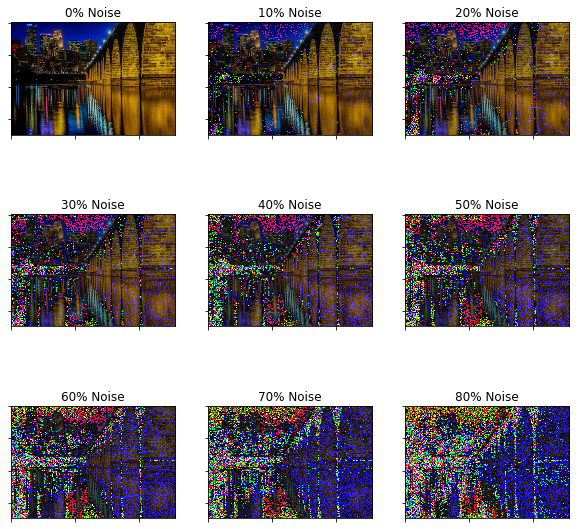

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))

noise_pct = 0.0
for x in range(3):
    for y in range(3):
        noisy_img = add_noise_to_image(content_image, noise_pct)
        imshow(noisy_img, ax[x][y], '{0:.0%} Noise'.format(noise_pct))
        noise_pct+= 0.1

In [41]:
sess = tf.InteractiveSession()

/Users/morgann/anaconda3/envs/foo/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [81]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S,(n_H*n_W,n_C)))
    a_G = tf.transpose(tf.reshape(a_G,(n_H*n_W,n_C)))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = 1 /(4*n_H*n_W*n_C*n_H*n_W*n_C)*(tf.reduce_sum(tf.square(tf.subtract(GS,GG))))
    
    ### END CODE HERE ###
    
    return J_style_layer


def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0
    coeff = 1 / len(STYLE_LAYERS)

    for layer_name in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

[('conv1_1', 0.2),
 ('conv2_1', 0.2),
 ('conv3_1', 0.2),
 ('conv4_1', 0.2),
 ('conv5_1', 0.2)]

In [63]:
content_cost

<tf.Tensor 'mul_43:0' shape=() dtype=float32>

In [64]:
style_cost

<tf.Tensor 'add_156:0' shape=() dtype=float32>

In [65]:
total_cost

<tf.Tensor 'add_157:0' shape=() dtype=float32>

In [57]:
generated_activation

<tf.Tensor 'Relu_89:0' shape=(1, 44, 64, 512) dtype=float32>

In [78]:
def model_nn(content_path,
             style_path,
             model_path,
             name,
             contentLayer='conv4_2',
             styleLayers=['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1'],
             noise_ratio=0.6,       
             num_iterations = 200):
    
    
    # Load images, resize, generate noisy image
    content_image = load_img(content_path).astype('uint8')
    style_image = load_img(style_path).astype('uint8')
    content_image, style_image = reshape_images(content_image, style_image)
    noisy_image = add_noise_to_image(content_image, ratio=noise_ratio)
    
    # load vgg model with specified dimensions, compute initial cost function
    vgg = load_vgg_model(model_path, content_image.shape)
    sess.run(vgg['input'].assign(content_image))

    content_activation = sess.run(vgg[contentLayer])
    generated_activation = vgg[contentLayer] # placeholder for now. will be updated later
    content_cost = compute_content_cost(content_activation, generated_activation)

    sess.run(vgg['input'].assign(style_image))
    style_cost = compute_style_cost(vgg, styleLayers)

    total_cost = compute_total_cost(content_cost, style_cost,
                                    alpha=10, beta=40)

    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(total_cost)
    

    # initialize global variables, run the noisy image, loop through epochs
    sess.run(tf.global_variables_initializer())
    sess.run(vgg['input'].assign(noisy_image))

    for i in range(num_iterations):

        sess.run(train_step)
        generated_image = sess.run(vgg['input'])
       # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([total_cost, content_cost, style_cost])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))

            # save current generated image in the "/output" directory
            path = 'output/{0}_{1}.png'.format(name, i)
            scipy.misc.imsave(path, deprocess_img(generated_image))

    # save last generated image
    path = 'output/{0}_final.png'.format(name, i)
    scipy.misc.imsave(path, deprocess_img(generated_image))

    return generated_image

In [72]:
model_nn(sess, generated_image, 'stonearch_e')

Iteration 0 :
total cost = 1.9735333e+17
content cost = 1.9735327e+16
style cost = 1545787600.0


/Users/morgann/anaconda3/envs/foo/lib/python3.6/site-packages/ipykernel/__main__.py:35: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Iteration 20 :
total cost = 4.0135237e+16
content cost = 4013520000000000.0
style cost = 949036500.0
Iteration 40 :
total cost = 1.7691602e+16
content cost = 1769156800000000.0
style cost = 866998600.0
Iteration 60 :
total cost = 1.0060081e+16
content cost = 1006004800000000.0
style cost = 838493400.0
Iteration 80 :
total cost = 6649994000000000.0
content cost = 664996100000000.0
style cost = 821800770.0
Iteration 100 :
total cost = 4800695000000000.0
content cost = 480066280000000.0
style cost = 811579700.0
Iteration 120 :
total cost = 3656542000000000.0
content cost = 365650970000000.0
style cost = 805011650.0
Iteration 140 :
total cost = 2873314000000000.0
content cost = 287328200000000.0
style cost = 800434750.0
Iteration 160 :
total cost = 2316287100000000.0
content cost = 231625520000000.0
style cost = 797017500.0
Iteration 180 :
total cost = 1898439000000000.0
content cost = 189840730000000.0
style cost = 794445900.0


/Users/morgann/anaconda3/envs/foo/lib/python3.6/site-packages/ipykernel/__main__.py:39: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


array([[[[ 9.09533157e+01,  2.43119488e+01,  1.36077261e+00],
         [ 3.59092216e+01, -1.26281605e+01, -1.91755161e+01],
         [ 4.59217567e+01, -1.18741179e+01, -2.78993702e+01],
         ...,
         [ 7.50451050e+01,  3.05606861e+01,  6.76614685e+01],
         [ 7.01716309e+01,  5.91732674e+01,  5.20558090e+01],
         [ 8.85128860e+01,  3.10063553e+01,  9.54223633e+01]],

        [[-1.80083084e+01, -9.01960754e+01, -9.02226334e+01],
         [-7.47149587e-01, -2.96505165e+01, -6.96416626e+01],
         [ 9.35183239e+00, -2.90135212e+01, -3.45980606e+01],
         ...,
         [-2.90951977e+01, -7.47434998e+01, -6.42650909e+01],
         [ 9.38542843e+00, -3.84273872e+01, -7.57632446e+01],
         [-5.81487541e+01, -7.06373978e+01, -1.23080368e+02]],

        [[-1.28140316e+01, -5.87195320e+01, -4.07908401e+01],
         [-8.28297138e+00, -1.56751471e+01,  5.88667107e+00],
         [-3.86437912e+01,  1.54858971e+00,  2.69628067e+01],
         ...,
         [ 1.26108734e+0

In [ ]:
model_nn(sess,
         content_path='data/content/stonearch.jpg',
         style_path='',
         model_path
         contentLayer,
         styleLayers,
         noise_ratio,       
         name,
         num_iterations = 200)

In [86]:
import styleTransfer

In [87]:
styleDict = {
    'a': ['conv1_1'],
    'b': ['conv1_1', 'conv2_1'],
    'c': ['conv1_1', 'conv2_1', 'conv3_1'],
    'd': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'],
    'e': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']   
}

styleTransfer.model_nn(
         sess,
         content_path='data/content/stonearch.jpg',
         style_path='data/style/rainPrincess.jpg',
         model_path='imagenet-vgg-verydeep-19.mat',
         contentLayer='conv4_2',
         styleLayers=styleDict['e'],
         noise_ratio=0.6,       
         name='stonearch3',
         num_iterations = 200)

/Users/morgann/anaconda3/envs/foo/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


NameError: name 'sess' is not defined

# Sources:

### Content:
[Stonearch Bridge](https://www.flickr.com/photos/11375428@N04/16995175861)

### Style:
[Rain Princess](https://afremov.com/images/product/RAIN-PRINCESS.jpg)


### Code:
[Neural Style Transfer - Raymond Yuan](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398)


### Theory:
https://arxiv.org/pdf/1508.06576.pdf